# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## ***Learner's notes are in bold italic to differentiate it from other text***

***Given the provided dataset, we need to find features that has a strong impact (strong positive and negative correlation) on the price of a car which is target in this case. That means that we need to find the model that fits the data the best, tune hyperparameters of the model and validate it with the test data derived from the given dataset.*** 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

***Import libraries***

In [1094]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score, PredictionErrorDisplay, mean_squared_error
import shap

***Loading dataset and understanding its basic properties***

In [1095]:
df=pd.read_csv("vehicles.csv")
df.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
150210,7310389948,evansville,30590,2017.0,acura,mdx sh-awd sport utility,good,NaN,other,44651.0,clean,other,5J8YD4H5XHL001778,NaN,NaN,other,black,in
296266,7312311734,columbus,6995,2009.0,infiniti,m35x,like new,6 cylinders,gas,176000.0,clean,automatic,NaN,4wd,full-size,sedan,grey,oh
240628,7315954255,raleigh / durham / CH,0,2006.0,chevrolet,silverado 1500 lt3,good,8 cylinders,gas,187904.0,clean,automatic,2GCEC13T761228521,rwd,NaN,pickup,blue,nc
27312,7311681476,fresno / madera,30833,2019.0,lexus,ux,NaN,NaN,gas,26049.0,clean,automatic,JTHY3JBH0K2010150,fwd,compact,wagon,silver,ca
185854,7316540173,boston,18600,2018.0,subaru,outback premium,excellent,4 cylinders,gas,63000.0,clean,automatic,NaN,4wd,mid-size,wagon,grey,ma


In [1096]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

***Univariate Analysis of the target***

/var/folders/6c/zq4qld_16vg83c0kckbckh5m0000gq/T/ipykernel_68172/3216089498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price']).set_title("Distribution of 'price' variable")


Text(0.5, 1.0, "Distribution of 'price' variable")

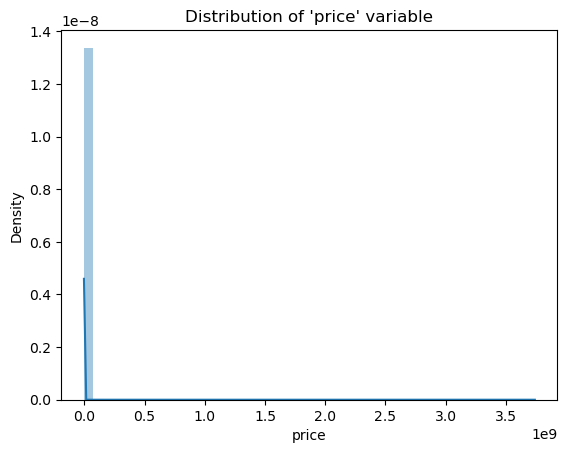

In [1097]:
sns.distplot(df['price']).set_title("Distribution of 'price' variable")

Text(0.5, 1.0, "QQ plot of 'price' variable")

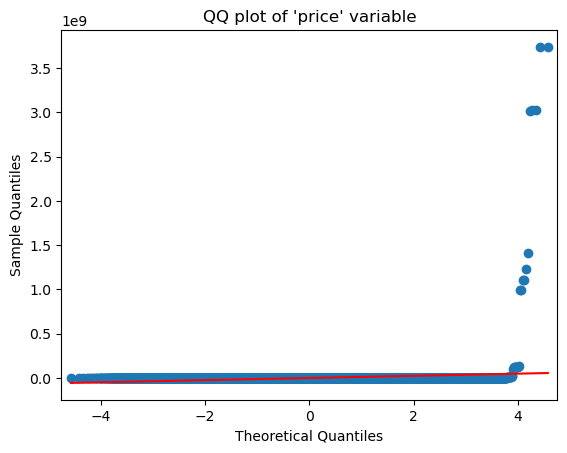

In [1098]:
fig = sm.qqplot(df['price'],line='s')
plt.title("QQ plot of 'price' variable")

***The target variable is not normaly distributed. We'll try to see if it changes after data preparation.***

***Bivariate Analysis and correlation matrix***

In [1099]:
#sns.pairplot(df) can't be executed on my machine
corr = df.corr(numeric_only = True).round(3)
corr

,id,price,year,odometer
id,1.000,-0.003,-0.059,0.011
price,-0.003,1.000,-0.005,0.010
year,-0.059,-0.005,1.000,-0.157
odometer,0.011,0.010,-0.157,1.000


***We don't see any signficant correlation on the numeric features***

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

***Missing values and deduplication***

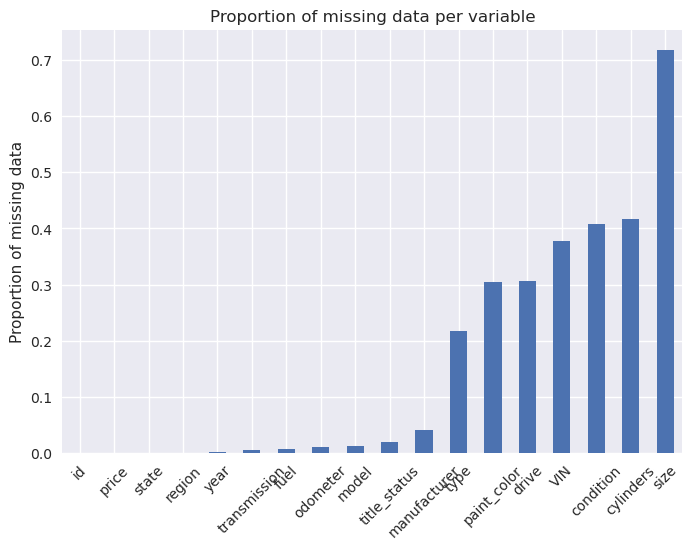

In [1100]:
with plt.style.context("seaborn"):
    df.isnull().mean().sort_values(ascending=True).plot.bar(rot=45)
    plt.ylabel("Proportion of missing data")
    plt.title("Proportion of missing data per variable")

***Given that we will need to transform non-numeric variables to numeric, we should consider dropping some features that have too many variables and/or duplicates. Also, number of variables in the model column seems to be unrealistically high, meaning that most likely there are duplicates, different spelling, etc. Normalizing this data is out of the scope for this project. We will also drop id and state columns as they should not impact the target.***

In [1101]:
df = df.drop(['id', 'region', 'model', 'state', 'condition', 'size'], axis=1)

In [1102]:
df = df.drop_duplicates(subset=['VIN'], keep='first')
df = df.drop('VIN', axis=1)

In [1103]:
df = df.drop_duplicates(keep=False)

In [1104]:
assert df.duplicated().sum() == 0

In [1105]:
df.shape

(117761, 11)

***Imputing values in the outstanding columns***

In [1106]:
cols = ['year', 'manufacturer', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'cylinders']
df[cols] = df[cols].apply(lambda x: x.fillna(x.mode()[0]))

***Data type conversion***

In [1107]:
df['year'] = (df['year']).astype(int)
df['odometer'] = df['odometer'].astype(int)

***Outliers***

***So far we don't have too many numeric columns, so we can detect outliers manually for each of them (price, year, odometer)***

In [1108]:
#checking min and max values for price
print(df.price.max())
df.price.min()

123456789


0

In [1109]:
price_low = df["price"].quantile(0.11)
price_high = df["price"].quantile(0.99998)
df = df[(df["price"] < price_high) & (df["price"] > price_low)]

In [1110]:
print(df.price.max())
df.price.min()

1000000


143

In [1111]:
print(df.odometer.max())
df.odometer.min()

10000000


0

In [1112]:
odometer_high = df["odometer"].quantile(0.9993)
df = df[(df["odometer"] < odometer_high)]
df.odometer.max()

725243

In [1113]:
df.shape

(104728, 11)

***After all data prep, let's run univariate analysis of the target again***

/var/folders/6c/zq4qld_16vg83c0kckbckh5m0000gq/T/ipykernel_68172/2559566985.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['price']).set_title("Distribution of 'price' variable after data cleaning")


Text(0.5, 1.0, "Distribution of 'price' variable after data cleaning")

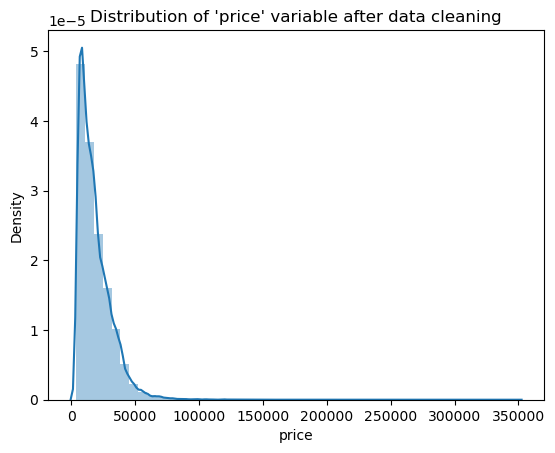

In [1114]:
sns.distplot(df2['price']).set_title("Distribution of 'price' variable after data cleaning")

Text(0.5, 1.0, "QQ plot of 'price' variable after data cleaning")

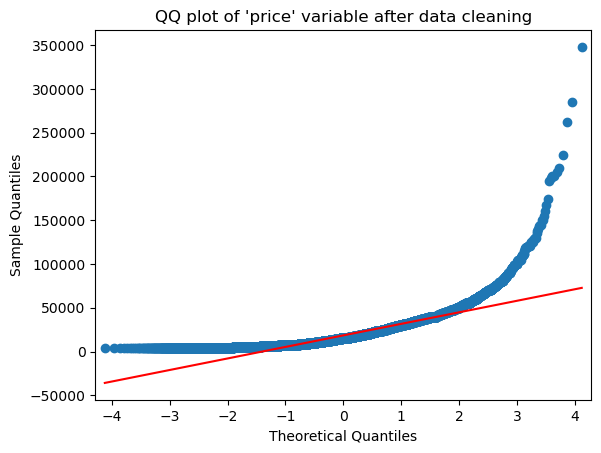

In [1115]:
fig = sm.qqplot(df2['price'],line='s')
plt.title("QQ plot of 'price' variable after data cleaning")

***While distribution is not perfect, it definitely improved. Will try target transformation later.*** 

***Encoding***

***Empirically, I was able to establish that mean encoding has the same impact on the models as the one hot encoding for this dataset, so I decided to use the mean encoding.***

In [1116]:
#splitting in training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=["price"], axis=1),  
    df["price"],  
    test_size=0.2,  
    random_state=0,  
)

X_train.shape, X_test.shape

((83782, 10), (20946, 10))

In [1117]:
mean_enc = TargetEncoder(cols=None, min_samples_leaf=25, smoothing=1.0)

In [1118]:
mean_enc.fit(X_train, y_train)

TargetEncoder(cols=['manufacturer', 'cylinders', 'fuel', 'title_status',
                    'transmission', 'drive', 'type', 'paint_color'],
              min_samples_leaf=25, smoothing=1.0)

In [1119]:
X_train_enc = mean_enc.transform(X_train)
X_test_enc = mean_enc.transform(X_test)

**Scaling**

In [1120]:
# standardisation with the StandardScaler from sklearn

scaler = StandardScaler()

scaler.fit(X_train_enc)

X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

### Modeling and Evaluation

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

***Few words about evaluation metric I'm using. According to the literature (Andreas Muller et al.), evaluation of regression models can be done using the default R2 that used in the score method of all regressors. Sometimes business decisions are made on the basic of mean squared error or mean absolute error, which might give incentive to tune models using these metrics. In general though, R2 was found to be a more intuitive metric to evaluate regression models. I will be performing cross-validation for all models as well.***

***Linear model***

In [1121]:
lr = LinearRegression().fit(X_train_scaled, y_train)

In [1122]:
print("Training set score: {:.2f}".format(lr.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_scaled, y_test)))

Training set score: 0.42
Test set score: 0.48


In [1072]:
scores_lr = cross_val_score(lr, X_test_scaled, y_test, cv=5)
scores_lr

array([0.48058213, 0.47061755, 0.47111739, 0.50849743, 0.4828601 ])

***Ridge model with default alpha***

In [1073]:
ridge = Ridge().fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test_scaled, y_test)))

Training set score: 0.42
Test set score: 0.48


In [1074]:
scores_ridge = cross_val_score(lr, X_test_scaled, y_test, cv=5)
scores_ridge

array([0.48058213, 0.47061755, 0.47111739, 0.50849743, 0.4828601 ])

***Finding an optimal alpha with GridSearchCV***

In [1075]:
params_dict = {'alpha': [0.1, 1.0, 10.0, 100.0]}

In [1076]:
ridge2 = Ridge()
grid = GridSearchCV(ridge2, param_grid=params_dict)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})

In [1077]:
best_alpha = grid.best_params_

In [1078]:
(f'Best alpha: {list(best_alpha.values())[0]}')

'Best alpha: 100.0'

***Ridge with the best alpha***

In [1079]:
ridge3 = Ridge(alpha=100).fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(ridge3.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(ridge3.score(X_test_scaled, y_test)))

Training set score: 0.42
Test set score: 0.48


In [1080]:
scores_ridge3 = cross_val_score(ridge3, X_test_scaled, y_test, cv=5)
scores_ridge3

array([0.48065665, 0.47069984, 0.47136037, 0.50849689, 0.48254538])

***Lasso with default parameters***

In [1081]:
lasso = Lasso().fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test_scaled, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.42
Test set score: 0.48
Number of features used: 10


In [1082]:
scores_lasso = cross_val_score(lasso, X_test_scaled, y_test, cv=5)
scores_lasso

array([0.48058349, 0.4706301 , 0.4711251 , 0.50850357, 0.48284448])

***Lasso with different parameters***

In [1083]:
lasso2 = Lasso(alpha=100.0, max_iter=100000).fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(lasso2.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(lasso2.score(X_test_scaled, y_test)))
print("Number of features used:", np.sum(lasso2.coef_ != 0))

Training set score: 0.42
Test set score: 0.48
Number of features used: 8


***Ridge regression with built-in cross-validation and target transformer***

In [1084]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

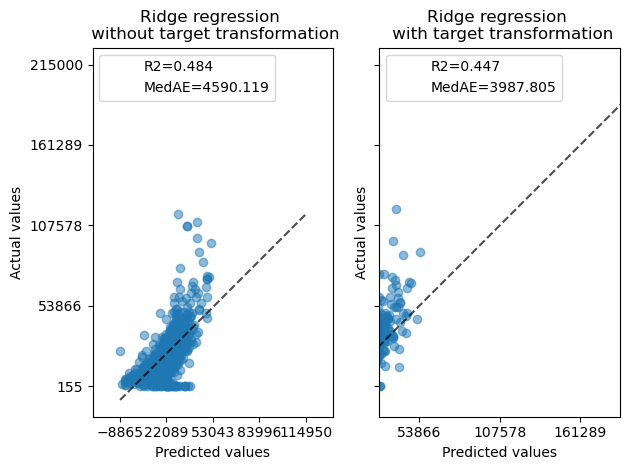

In [1085]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV(alphas=100.0).fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(alphas=100.0), func=np.log1p, inverse_func=np.expm1
).fit(X_train_scaled, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test_scaled)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
plt.tight_layout()

***As we can see, R2 and cross-validations scores are very consistent acrross multiple models. Target transformation improved MedAE but not dramatically.***

### Results

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

***Since all the models scored pretty much the same way, we can take either one of them to derive feature importance. We will do it in two ways: 1) Analyzing model coefficients 2) Using a popular library Shap.***

In [1123]:
feature_names = X_train_enc.columns

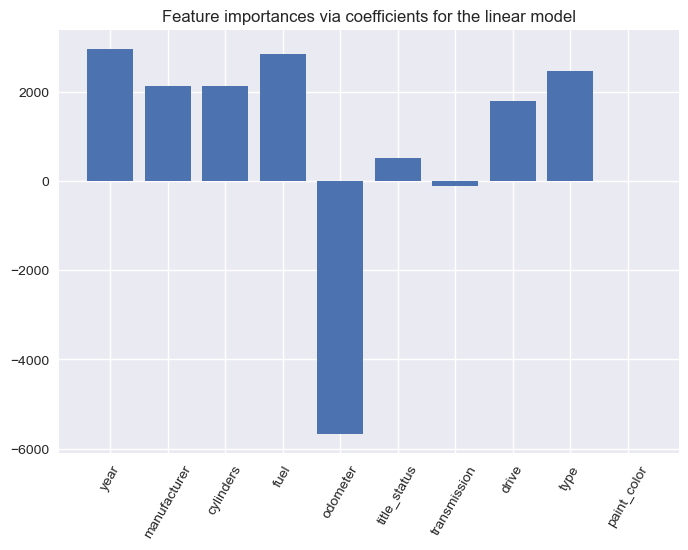

In [1124]:
with plt.style.context("seaborn"):
    plt.bar(height=lr.coef_, x=feature_names)
    plt.title("Feature importances via coefficients for the linear model")
    plt.xticks(rotation=60)
    plt.show()

In [1125]:
# Create object that can calculate shap values
explainer = shap.LinearExplainer(lr, X_train_scaled)
# Calculate Shap values
shap_values = explainer.shap_values(X_train_scaled)

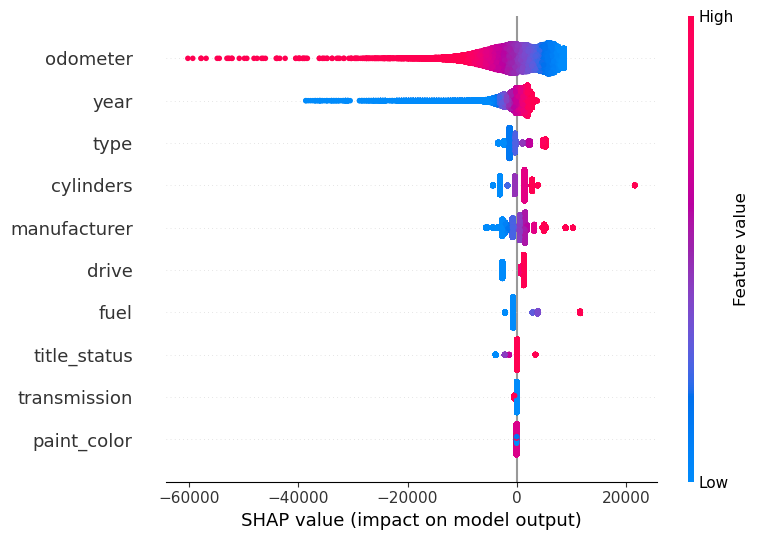

In [1126]:
shap.summary_plot(shap_values, X_train_scaled, feature_names)

***Interpretation of linear coefficients***

***As we know, the sign of a linear regression coefficient indicates whether there is a positive or negative correlation between each independent variable and the dependent variable. We see there is only one independent variable, "odometer", has a strong negative relationship with the price target. Which makes sense, the more miles car had driven, the less valuable it becomes.***

***Absolute values of coefficients indicate the strength of the relationship between variables using values that retain the natural units of the dependent variable. Effect sizes helps us understand how important the findings are in a practical sense. We can see that aside from the odometer variable, there are six more variable that display sizeable effect.***

***We get similar results from Shap. As we can see from the Shap plot, the higher odometor values negatively impact the price. While lower values of year also negatively impact the price which makes sense.***

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

***While R2 scores of the models are not very high, they are not very low eithier and still can be useful. Some fields of study have an inherently greater amount of unexplainable variation. In these areas, R2 values are bound to be lower. For example, studies that try to explain human behavior generally have R2 values less than 0.5.***

***The report***

***Dear sellers,*** 

***I'd like to discuss what factors or properties of a used car make it less or more expensive from a buyer's perspective and what you can do it about it. As we all know, different buyers value different things in a car. For example, someone who likes music will be looking at an acoustic system and properties of a car, someone who doesn't like music, wouldn't really care about it that much. Therefore, we will be looking at properties of a car that are important for the vast majority of the buyers.***

***According to the analysis, the two most important properties are current milage and year when the car was made. The bigger value of the odometer is, the lower price a customer is willing to pay for a car. The opposite is also true, customers are willing to pay more money for the cars with lower milage. Regarding the year of a car, the older car is, less valuable the car becomes from a buyer perspective. Other importance factors that impact the value of a car are the make of a car and the type (sedan, SUV, etc.). The condition of a care doesn't seem to be a strong factor. That's most likely due to the fact (unless the body is visibly damaged), that a true condition of internal important parts of the car(engine, brakes, etc.) is unknown most of the time.***

***Based on this analysis, we recommend the following: 1) Don't let the original sellers to leverage any other properties of a car to get a better deal with you. Remember, the most important properties are current milage and the year. As an example, If a car was manufactured many years ago and has a lot of miles on it, it doesn't really matter if it has an unusual color. 2) In order to maximize the revenue, our recommendation is to focus on buying (from the original owners) cars manufactured in recent years and that have low odometer values.***